In [ ]:
import torch
from torch import nn
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import time
from sklearn.manifold import TSNE
import torchvision.utils as vutils

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### DATASET: FashionMNIST
FashionMNIST es un conjunto de datos de imágenes utilizado para tareas de clasificación en aprendizaje automático.
- Contiene 70,000 imágenes en escala de grises de 28x28 píxeles.
- Cada imagen representa una prenda de ropa, como camisetas, pantalones, zapatos, etc.
- Hay 10 clases diferentes, cada una correspondiente a un tipo de prenda.
- El dataset está dividido en 60,000 imágenes para entrenamiento y 10,000 para prueba.
- Es una alternativa moderna al clásico MNIST (dígitos escritos a mano), proporcionando un reto mayor para los modelos de clasificación.

Las clases de FashionMNIST son:
* 0: T-shirt/top (Camiseta/Top)
* 1: Trouser (Pantalón)
* 2: Pullover (Jersey/Suéter)
* 3: Dress (Vestido)
* 4: Coat (Abrigo)
* 5: Sandal (Sandalia)
* 6: Shirt (Camisa)
* 7: Sneaker (Zapatilla deportiva)
* 8: Bag (Bolso)
* 9: Ankle boot (Bota corta)

In [ ]:
# Usamos transforms.ToTensor() para convertir las imágenes a tensores de PyTorch
# y transforms.Normalize() para normalizar los valores de píxeles a la media 0 y desviación estándar 1.
# el rango original [0, 1] pasa a [-1, 1].
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Creamos los DataLoader para cargar los datos en lotes (batches) durante el entrenamiento y la evaluación.
# El DataLoader mezcla (shuffle) los datos de entrenamiento para mejorar el aprendizaje, pero no los de prueba.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.82MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.8MB/s]


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

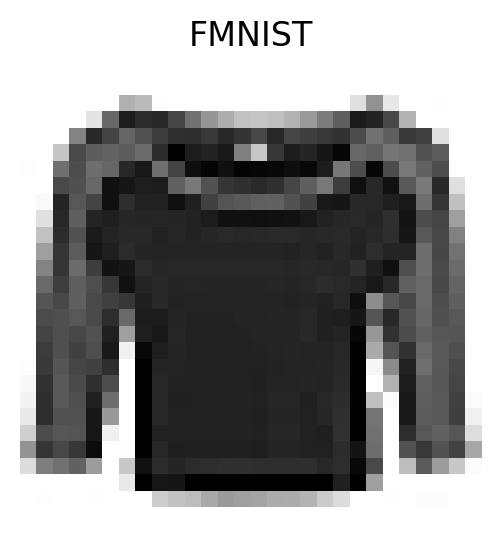

In [ ]:
# Visualización de una imagen del batch
# - images[0]: la primera imagen del lote.
# - .numpy(): convierte el tensor de PyTorch a un array de NumPy.
# - .squeeze(): elimina dimensiones de tamaño 1 (de (1, 28, 28) a (28, 28)).
# - cmap='gray_r': usa un mapa de colores en escala de grises, invertido (0 es blanco y 1 es negro).

def rescale(img):
    # Desnormaliza: si tus datos están normalizados en [-1, 1],
    # esto los lleva de nuevo al rango [0, 1] (visible como imagen)
    img = img / 2 + 0.5

    # Convierte el tensor a array de NumPy
    npimg = img.numpy()

    # Cambia el orden de ejes de (C, H, W) a (H, W, C),
    # que es lo que matplotlib espera
    return np.transpose(npimg, (1, 2, 0))

fig, axs = plt.subplots(1, 1, figsize=(3, 3))

# FMNIST
traindata = iter(train_loader)
images, labels = next(traindata)
axs.imshow(rescale(images[0]),cmap='gray_r')
axs.set_title(f"FMNIST")
axs.axis("off")


### **1. IMPLEMENTACIÓN DE UNA CVAE CON PRIOR INDEPENDIENTE**

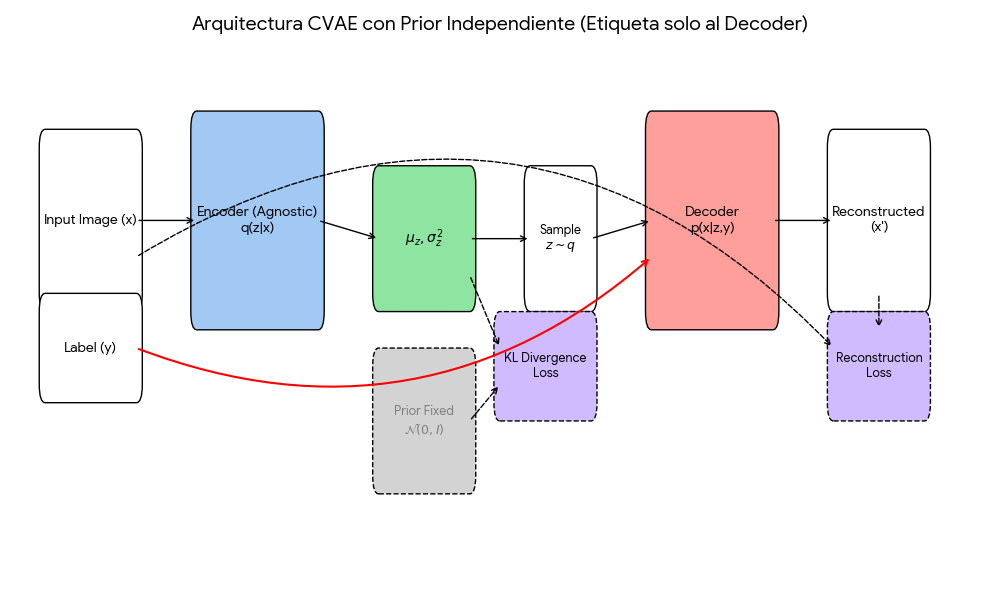

In [ ]:
class encoder(nn.Module):

    def __init__(self, dimz, channels=1, var_x=0.1):
        """
        Encoder optimizado para Fashion MNIST (28x28).
        Reduce la imagen progresivamente hasta un mapa de 1x1x256
        y luego extrae media y varianza.
        """
        super().__init__()
        self.dimz = dimz # dimz = dimensión del espacio latente

        # 1. (28 -> 14)
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()

        # 2. (14 -> 7)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1)

        # 3. (7 -> 3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        # 4. (3 -> 1) .
        self.conv4 = nn.Conv2d(64, 256, kernel_size=4, stride=2, padding=1)

        # La salida es dimz * 2 porque necesitamos predecir Media (mu) y Varianza (sigma)
        self.linear = nn.Linear(256, dimz * 2)
        self.softplus = nn.Softplus() # Para asegurar varianza positiva

    def forward(self, x):

        z = self.relu(self.conv1(x))
        z = self.relu(self.conv2(z))
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))

        # Convertimos el tensor 3D (Canales, Alto, Ancho) en vector 1D
        # z.size(0) es el tamaño del batch. -1 infiere el resto (256).
        z = z.view(z.size(0), -1)
        z = self.linear(z) # Salida: (Batch, dimz * 2)
        return z


    def encode_and_sample(self, x, flag_sample=True):
        """
        Calcula media y varianza del espacio latente y genera una muestra
        usando el truco de reparametrización.
        """
        z = self.forward(x)

        # Dividir el vector en dos partes iguales
        # Primera mitad: Vector de Medias (mu)
        mu = z[:, :self.dimz]

        # Segunda mitad: Vector de Varianzas (sigma^2)
        # Usamos softplus para asegurar que sea > 0, ya que una varianza no puede ser negativa.
        var = self.softplus(0.5 * z[:, self.dimz:])
        sample = None

        if flag_sample:
          # --- REPARAMETERIZATION TRICK ---
            # z = mu + epsilon * sigma
            # epsilon: Ruido normal N(0, 1)
            eps = torch.randn_like(var)
            sample = mu + eps * (var ** 0.5)
        return mu, var, sample



In [ ]:
class decoder(nn.Module):

    def __init__(self, dimz, num_classes=10, embed_dim=10, channels=1, var_x=0.1):
        """
        Decoder de una VAE para Fashion MNIST (28x28).
        Toma un vector latente z y una etiqueta, y reconstruye una imagen.
        """
        super().__init__()

        # Embedding para la etiqueta ---
        # Convierte un entero (ej: 5) en un vector denso (ej: [0.1, -0.5, ...])
        self.embed = nn.Embedding(num_classes, embed_dim)

        # Entrada: dimz (latente) + embed_dim (etiqueta)
        # Salida: 256 neuronas que luego reformatearemos espacialmente
        self.linear = nn.Linear(dimz + embed_dim, 256)

        self.relu = nn.ReLU()

        # Tanh se usa porque se normalizaron las imágenes de entrada a [-1, 1]
        self.tanh = nn.Tanh()

        # --- CAPAS TRANSPOSED CONV (UPSAMPLING) ---

        # Capa 1: Mantener 1x1, reducir canales
        # Input: (256, 1, 1) -> Output: (64, 1, 1)
        self.tconv1 = nn.ConvTranspose2d(256, 64, kernel_size=1, stride=1, padding=0)

        # Capa 2: Expandir de 1x1 a 3x3
        self.tconv2 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=0)

        # Capa 3: Expandir de 3x3 a 7x7
        self.tconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0)

        # Capa 4: Expandir de 7x7 a 14x14
        self.tconv4 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)

        # Capa 5: Expandir de 14x14 a 28x28 (Tamaño final FMNIST)
        self.tconv5 = nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2, padding=1)


    def forward(self, z, labels):
        # 1. Preparar la condición (Etiqueta)
        # labels: (Batch) -> y_emb: (Batch, embed_dim)
        y_emb = self.embed(labels)

        # 2. Concatenar Latente + Etiqueta
        # z: (Batch, dimz)
        # z_input: (Batch, dimz + embed_dim)
        z = torch.cat([z, y_emb], dim=1)

        # 3. Proyección Lineal y Reformateo
        # Salida linear: (Batch, 256)
        # View: Transformamos el vector plano en un tensor 3D (mapa de características)
        # x: (Batch, 256, 1, 1)
        x = self.relu(self.linear(z).view(-1, 256, 1, 1))

        # 4. Upsampling Progresivo

        # Entrada: (Batch, 256, 1, 1)
        x = self.relu(self.tconv1(x))
        # Salida:  (Batch, 64, 1, 1)

        # Entrada: (Batch, 64, 1, 1)
        x = self.relu(self.tconv2(x))
        # Salida:  (Batch, 64, 3, 3)

        # Entrada: (Batch, 64, 3, 3)
        x = self.relu(self.tconv3(x))
        # Salida:  (Batch, 32, 7, 7)

        # Entrada: (Batch, 32, 7, 7)
        x = self.relu(self.tconv4(x))
        # Salida:  (Batch, 32, 14, 14)

        # Entrada: (Batch, 32, 14, 14)
        x = self.tanh(self.tconv5(x))
        # Salida Final: (Batch, 1, 28, 28)

        return x

    def decode(self, z, labels):
        return self.forward(z, labels)


In [ ]:
# --- FUNCIÓN DE LOG-LIKELIHOOD  ---
def eval_Gaussian_LL(x, mu_x, var_x):
    """
    Calcula el Log-Likelihood de los datos x dado la media mu_x y varianza fija var_x.
    Matemáticamente: log p(x|z, y)
    """
    # x, mu_x: [Batch, Channels, Height, Width]
    # Aplanamos para calcular sobre todos los píxeles: [Batch, Features]
    D = x.shape[1] * x.shape[2] * x.shape[3]
    x_flat = x.reshape(x.shape[0], -1)
    mu_x = mu_x.reshape(mu_x.shape[0], -1)

    # Creamos tensor de varianza
    var_x = torch.ones_like(x_flat) * var_x

    # 1. Término constante de la Gaussiana: -0.5 * D * log(2π) - 0.5 * sum(log(var))
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # 2. Término cuadrático (Error de reconstrucción ponderado): (x - mu)^2 / var
    # Si var_x es pequeño, este término penaliza mucho los errores.

    # Log-likelihood por imagen
    logp_data = -0.5 * (cnt + torch.sum((x_flat - mu_x) * var_x ** -1 * (x_flat - mu_x), dim=-1))

    # Suma total del batch (para el loss)
    logp = torch.sum(logp_data)

    return logp, logp_data

In [ ]:
class CVAE(nn.Module):
    def __init__(self, dimz, num_classes=10, embed_dim=10, channels=1, var_x=0.1):
        super().__init__()
        self.var_x = var_x # Varianza fija (Hiperparámetro)
        self.dimz = dimz

        # Encoder: NO condicional
        self.encoder = encoder(dimz=dimz, channels=channels, var_x=var_x)

        # Decoder: SI condicional
        self.decoder = decoder(dimz=dimz, num_classes=num_classes,
                               embed_dim=embed_dim, channels=channels, var_x=var_x)

    def forward(self, x, labels):
        # 1. Encoder ve solo la imagen -> q(z|x)
        mu_z, var_z, sample_z = self.encoder.encode_and_sample(x)

        # 2. Decoder ve latente + etiqueta -> p(x|z, y)
        mu_x = self.decoder.decode(sample_z, labels)

        return mu_x, mu_z, var_z

    def loss_function(self, x, mu_x, mu_z, var_z):
        """
        Calcula la función de pérdida total (Loss) para el CVAE.
        Queremos MAXIMIZAR el ELBO (Evidence Lower Bound).
        ELBO = E_q[log p(x | z, y)] - KL(q(z | x) || p(z))

        Como en PyTorch los optimizadores MINIMIZAN, calculamos el "Negative ELBO":
        Loss = -ELBO = -log p(x | z, y) + KL(q(z | x) || p(z))
        """
        # 1. Reconstrucción: log p(x | z, y)
        logp, _ = eval_Gaussian_LL(x, mu_x, self.var_x)

        # 2. KL Divergence: KL( q(z|x) || p(z) )
        # Prior independiente p(z) = N(0, I)
        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # Maximizamos (logp - KL) => Minimizamos -(logp - KL)
        total_loss = -logp + KLz

        return total_loss, -logp, KLz

In [ ]:
class CVAE_extended(CVAE):

    def __init__(self, dimz, num_classes=10, embed_dim=10, channels=1, var_x=0.1,
                 lr=1e-3, epochs=20):

        # Inicializa la clase padre (CVAE Prior Independiente)
        super().__init__(dimz, num_classes, embed_dim, channels, var_x)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        # Historiales para gráficas
        self.loss_history = []
        self.recon_history = []
        self.kl_history = []

        self.val_loss_history = []
        self.val_recon_history = []
        self.val_kl_history = []

    def trainloop(self, trainloader, valloader): # Acepta train y val
        print(f"Iniciando entrenamiento (Prior Independiente) en: {self.device}")

        for e in range(int(self.epochs)):
            # --- FASE 1: ENTRENAMIENTO ---
            self.train()
            train_loss, train_rec, train_kl = 0, 0, 0

            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                # 1. Forward (Solo devuelve 3 valores)
                mu_x, mu_z, var_z = self.forward(images, labels)

                # 2. Loss
                loss, rec, kl = self.loss_function(images, mu_x, mu_z, var_z)

                loss.backward()
                self.optim.step()

                train_loss += loss.item()
                train_rec += rec.item()
                train_kl += kl.item()

            # --- FASE 2: VALIDACIÓN ---
            self.eval()
            val_loss, val_rec, val_kl = 0, 0, 0

            with torch.no_grad():
                for x, y in valloader:
                    x, y = x.to(self.device), y.to(self.device)

                    # Forward y Loss (Igual que train)
                    mu_x, mu_z, var_z = self.forward(x, y)
                    loss, rec, kl = self.loss_function(x, mu_x, mu_z, var_z)

                    val_loss += loss.item(); val_rec += rec.item(); val_kl += kl.item()

            # --- GUARDAR MÉTRICAS ---
            n_train = len(trainloader)
            n_val = len(valloader)

            self.loss_history.append(train_loss / n_train)
            self.recon_history.append(train_rec / n_train)
            self.kl_history.append(train_kl / n_train)

            self.val_loss_history.append(val_loss / n_val)
            self.val_recon_history.append(val_rec / n_val)
            self.val_kl_history.append(val_kl / n_val)

            print(f'Epoch {e+1:2d} | '
                  f'Train [Loss: {self.loss_history[-1]:.1f} | Rec: {self.recon_history[-1]:.1f} | KL: {self.kl_history[-1]:.1f}] | '
                  f'Val [Loss: {self.val_loss_history[-1]:.1f} | Rec: {self.val_recon_history[-1]:.1f} | KL: {self.val_kl_history[-1]:.1f}]')

    def sample(self, num_imgs, specific_label=None):
        """
        Genera imágenes usando el Prior Estándar N(0, I).
        """
        self.eval()
        with torch.no_grad():
            # Ruido estándar (Prior Independiente)
            eps = torch.randn([num_imgs, self.dimz]).to(self.device)

            if specific_label is not None:
                labels = torch.full((num_imgs,), specific_label, dtype=torch.long).to(self.device)
            else:
                labels = torch.randint(0, 10, (num_imgs,)).to(self.device)

            x_sample = self.decoder.decode(eps, labels)
            return x_sample.cpu()

In [ ]:
cvae = CVAE_extended(
    dimz=16,
    num_classes=10,
    embed_dim=10,
    channels=1,
    var_x=0.1,
    lr=1e-3,
    epochs=50,
)

In [ ]:
cvae.trainloop(train_loader,test_loader)

Iniciando entrenamiento (Prior Independiente) en: cuda
Epoch  1 | Train [Loss: 18749.3 | Rec: 17071.1 | KL: 1678.2] | Val [Loss: 9543.9 | Rec: 7775.4 | KL: 1768.4]
Epoch  2 | Train [Loss: 8050.2 | Rec: 6303.3 | KL: 1747.0] | Val [Loss: 6836.8 | Rec: 5113.0 | KL: 1723.8]
Epoch  3 | Train [Loss: 6047.1 | Rec: 4321.5 | KL: 1725.6] | Val [Loss: 5738.8 | Rec: 4015.4 | KL: 1723.4]
Epoch  4 | Train [Loss: 4878.5 | Rec: 3142.9 | KL: 1735.6] | Val [Loss: 5103.9 | Rec: 3370.5 | KL: 1733.4]
Epoch  5 | Train [Loss: 4008.7 | Rec: 2247.8 | KL: 1760.9] | Val [Loss: 3962.7 | Rec: 2251.3 | KL: 1711.5]
Epoch  6 | Train [Loss: 3358.6 | Rec: 1565.8 | KL: 1792.8] | Val [Loss: 3768.0 | Rec: 2009.0 | KL: 1758.9]
Epoch  7 | Train [Loss: 2850.2 | Rec: 1031.2 | KL: 1819.0] | Val [Loss: 2860.7 | Rec: 1075.8 | KL: 1784.8]
Epoch  8 | Train [Loss: 2463.6 | Rec: 630.9 | KL: 1832.6] | Val [Loss: 2865.1 | Rec: 1078.8 | KL: 1786.4]
Epoch  9 | Train [Loss: 2248.9 | Rec: 408.3 | KL: 1840.6] | Val [Loss: 2388.3 | Rec: 532

In [ ]:
def plot_metrics(history):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # --- Gráfica 1: Loss Total ---
    ax[0].plot(history['loss'], 'b-', label='Train')
    ax[0].plot(history['val_loss'], 'b--', label='Validation') # Línea punteada
    ax[0].set_title('Total Loss (-ELBO)')
    ax[0].set_xlabel('Epochs')
    ax[0].grid(True, alpha=0.3)
    ax[0].legend() # Muestra la leyenda

    # --- Gráfica 2: KL Divergence ---
    ax[1].plot(history['kl'], 'r-', label='Train')
    ax[1].plot(history['val_kl'], 'r--', label='Validation')
    ax[1].set_title('KL Divergence')
    ax[1].set_xlabel('Epochs')
    ax[1].grid(True, alpha=0.3)
    ax[1].legend()

    # --- Gráfica 3: Reconstruction ---
    ax[2].plot(history['recon'], 'g-', label='Train')
    ax[2].plot(history['val_recon'], 'g--', label='Validation')
    ax[2].set_title('Reconstruction Loss')
    ax[2].set_xlabel('Epochs')
    ax[2].grid(True, alpha=0.3)
    ax[2].legend()

    plt.tight_layout()
    plt.show()

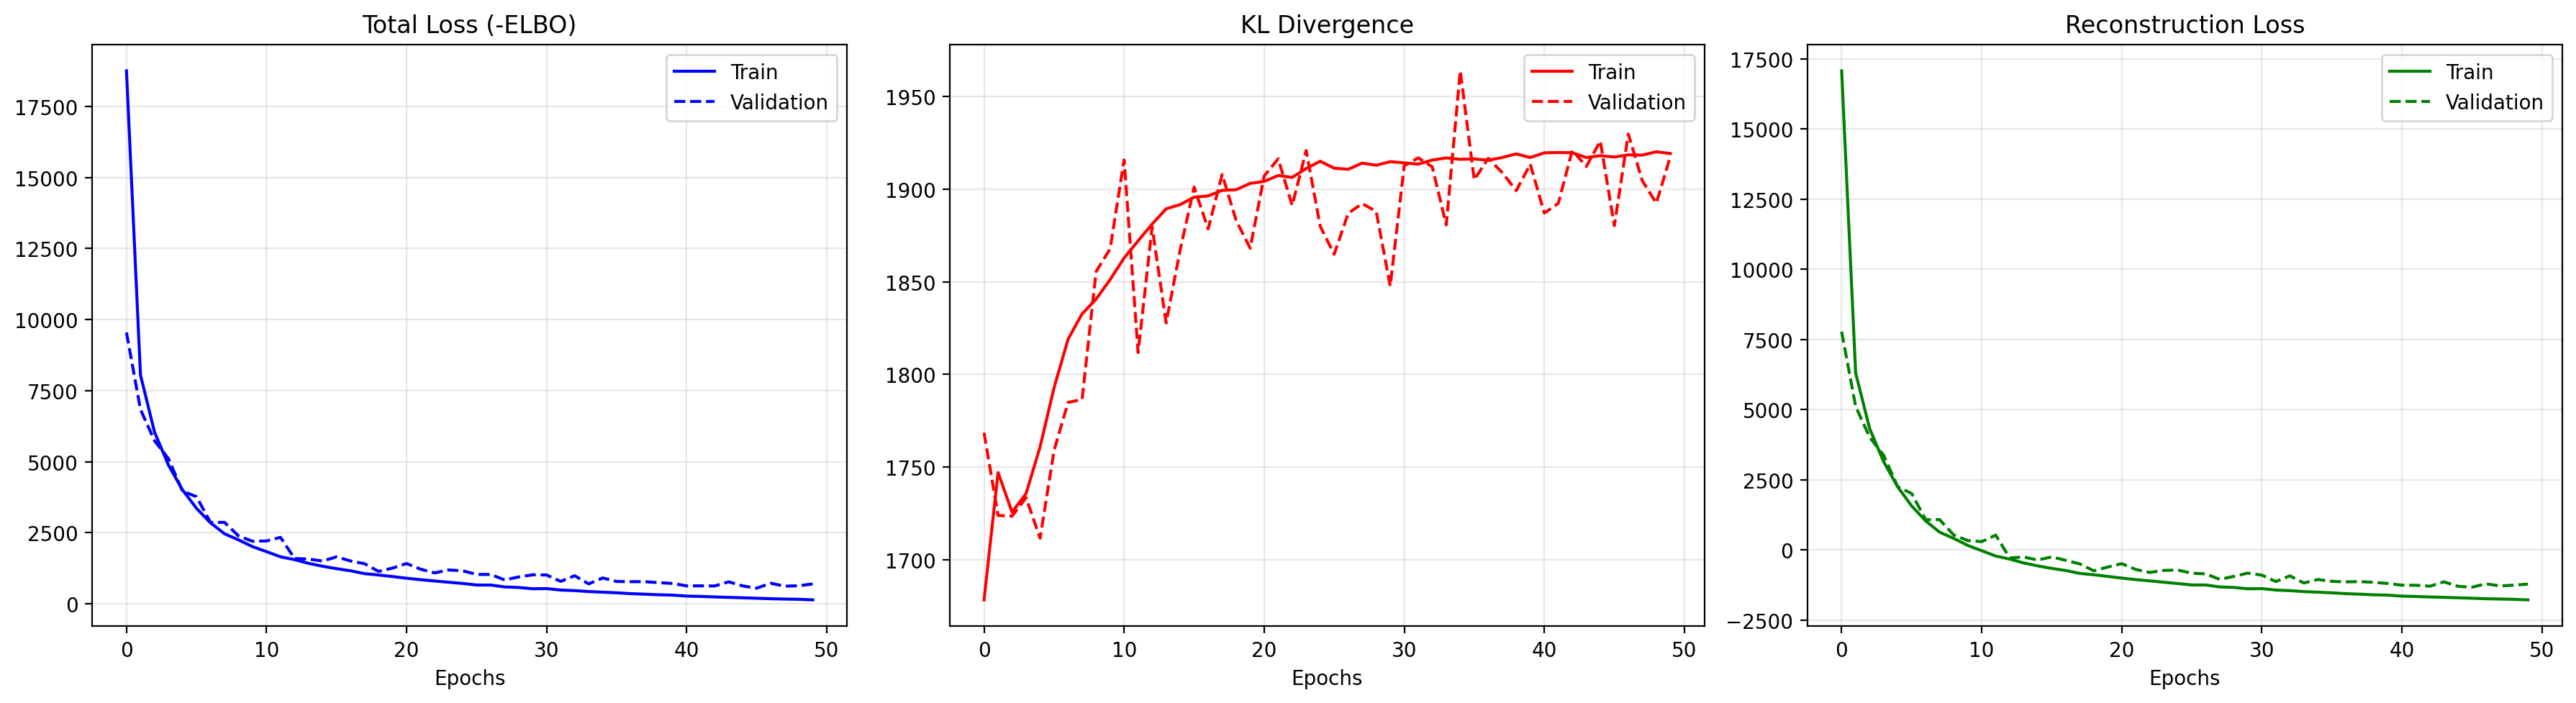

In [ ]:
history_data = {
    'loss': cvae.loss_history,
    'val_loss': cvae.val_loss_history,

    'kl': cvae.kl_history,
    'val_kl': cvae.val_kl_history,

    'recon': cvae.recon_history,
    'val_recon': cvae.val_recon_history
}

# Llamamos a la función
plot_metrics(history_data)

#### **1.2 Visualización de la Generación y el Espacio Latente**

Una vez entrenado el modelo, evaluamos cualitativamente su capacidad para separar la información de la clase ($\mathbf{y}$) de la información de estilo ($\mathbf{z}$). Realizaremos dos experimentos:

**A) Generación Condicional de Muestras**

El objetivo es verificar que el Decoder $p_\theta(\mathbf{x} \mid \mathbf{z}, \mathbf{y})$ utiliza correctamente la etiqueta proporcionada para determinar el tipo de prenda, mientras usa el vector latente para definir los detalles visuales.

*  Generaremos una cuadrícula donde cada fila corresponde a una clase distinta ($0-9$).

*  Cada columna comparte el mismo vector de ruido latente fijo $\mathbf{z} \sim \mathcal{N}(0, I)$.

Esperamos ver: Que la identidad del objeto cambie fila a fila (pantalón, camiseta, etc.), pero que se mantenga un "estilo" similar por columnas (ej. grosor, inclinación).

In [ ]:
def visualize_generation(model, num_samples=5, title="Generación"):
    model.eval()

    # Nombres de las clases de Fashion MNIST
    class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

    plt.figure(figsize=(num_samples, 10))

    for y in range(10):
        # El método sample ya maneja la lógica interna de cada modelo
        imgs = model.sample(num_samples, y).cpu()

        for i in range(num_samples):
            ax = plt.subplot(10, num_samples, y*num_samples + i + 1)

            # Desnormalizar: [-1, 1] -> [0, 1]
            ax.imshow((imgs[i].squeeze()+1)/2, cmap='gray')
            ax.axis('off')

            # Poner el nombre de la categoría solo en la primera columna
            if i == 0:
                ax.set_title(f"{class_names[y]}", fontsize=9, loc='left')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Para llamarla:
# visualize_generation(model, num_samples=5, title="Generación Condicional con Nombres")

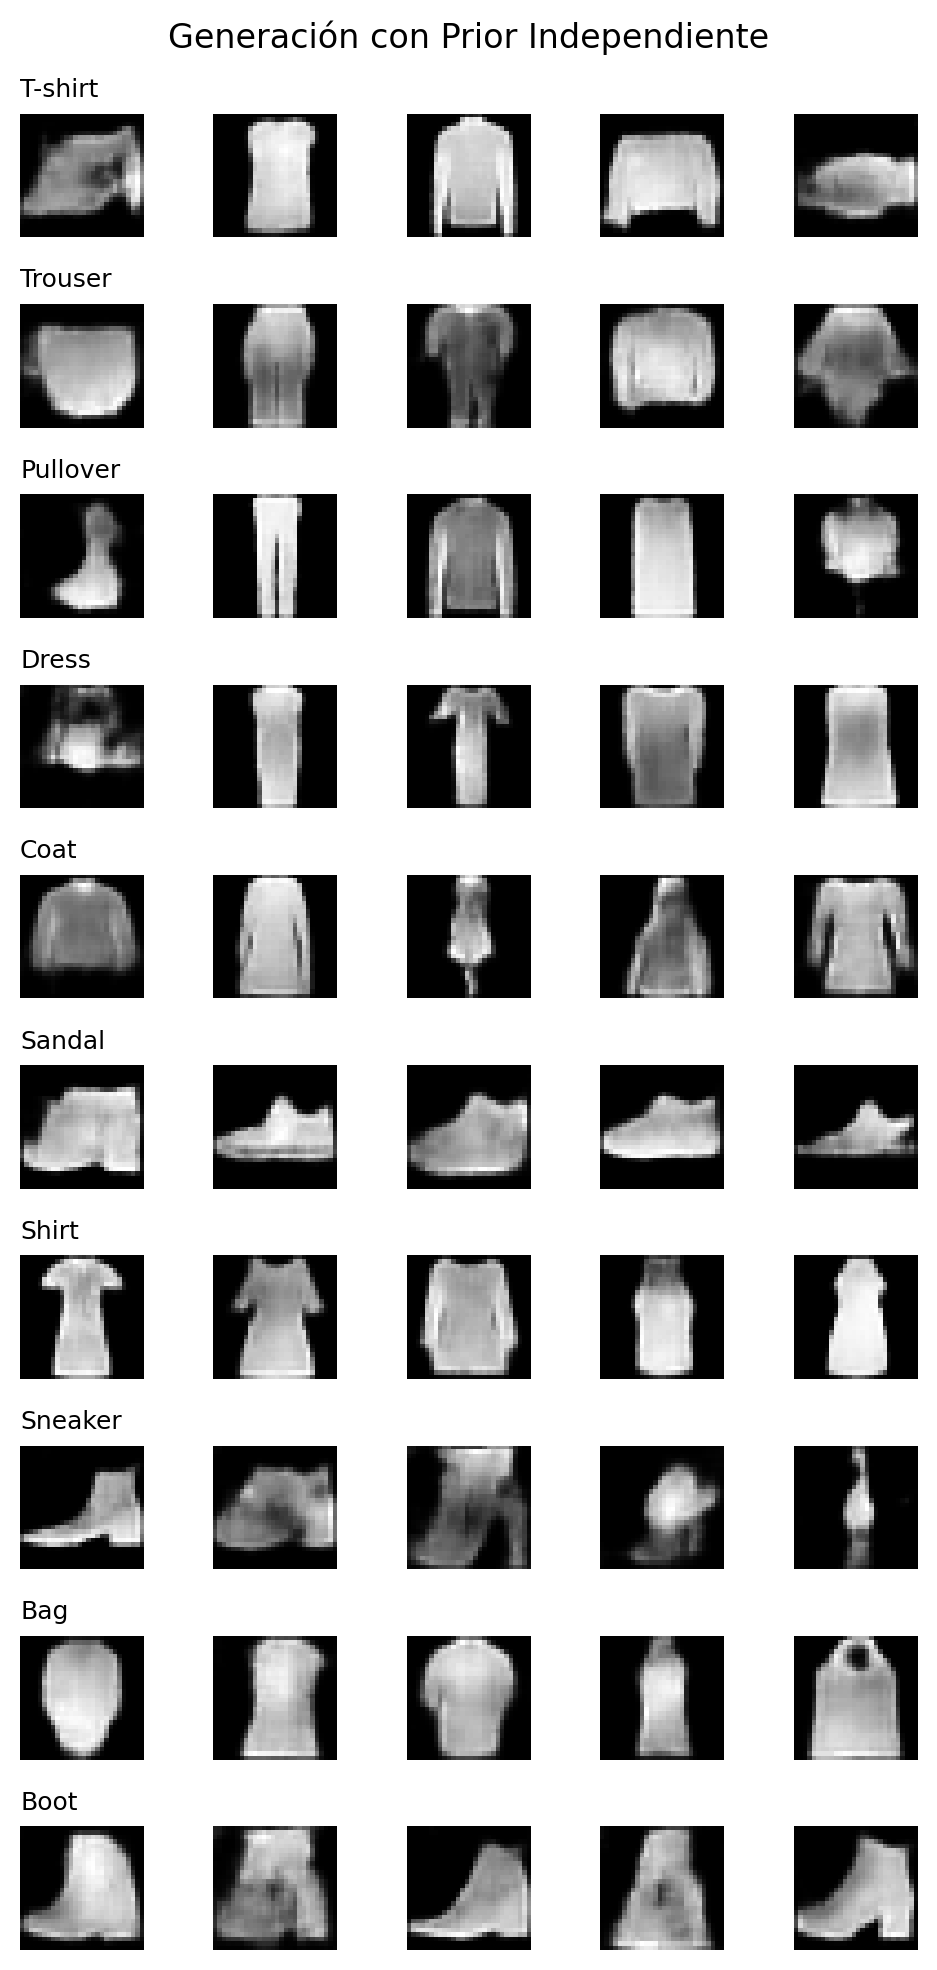

In [ ]:
# Llama a la función pasando tu modelo
visualize_generation(cvae, num_samples=5, title="Generación con Prior Independiente")

**B) Visualización del Espacio Latente (t-SNE)**

Usamos el Encoder $q_\phi(\mathbf{z} \mid \mathbf{x})$ (que es agnóstico a la etiqueta en nuestra arquitectura) para proyectar imágenes reales del conjunto de datos al espacio latente de 16 dimensiones.

* Utilizamos el algoritmo t-SNE para reducir la dimensionalidad de $16 \to 2$ y
visualizar la distribución de los puntos.

* Coloreamos los puntos según su clase real.

Esperamos ver: Agrupaciones (clusters) naturales donde prendas similares (ej. sandalias, zapatillas y botas) estén más cerca entre sí que de prendas de ropa (ej. abrigos), demostrando que el encoder ha aprendido una representación semántica de las imágenes basándose en su apariencia visual.

Calculando t-SNE sobre 1280 puntos...


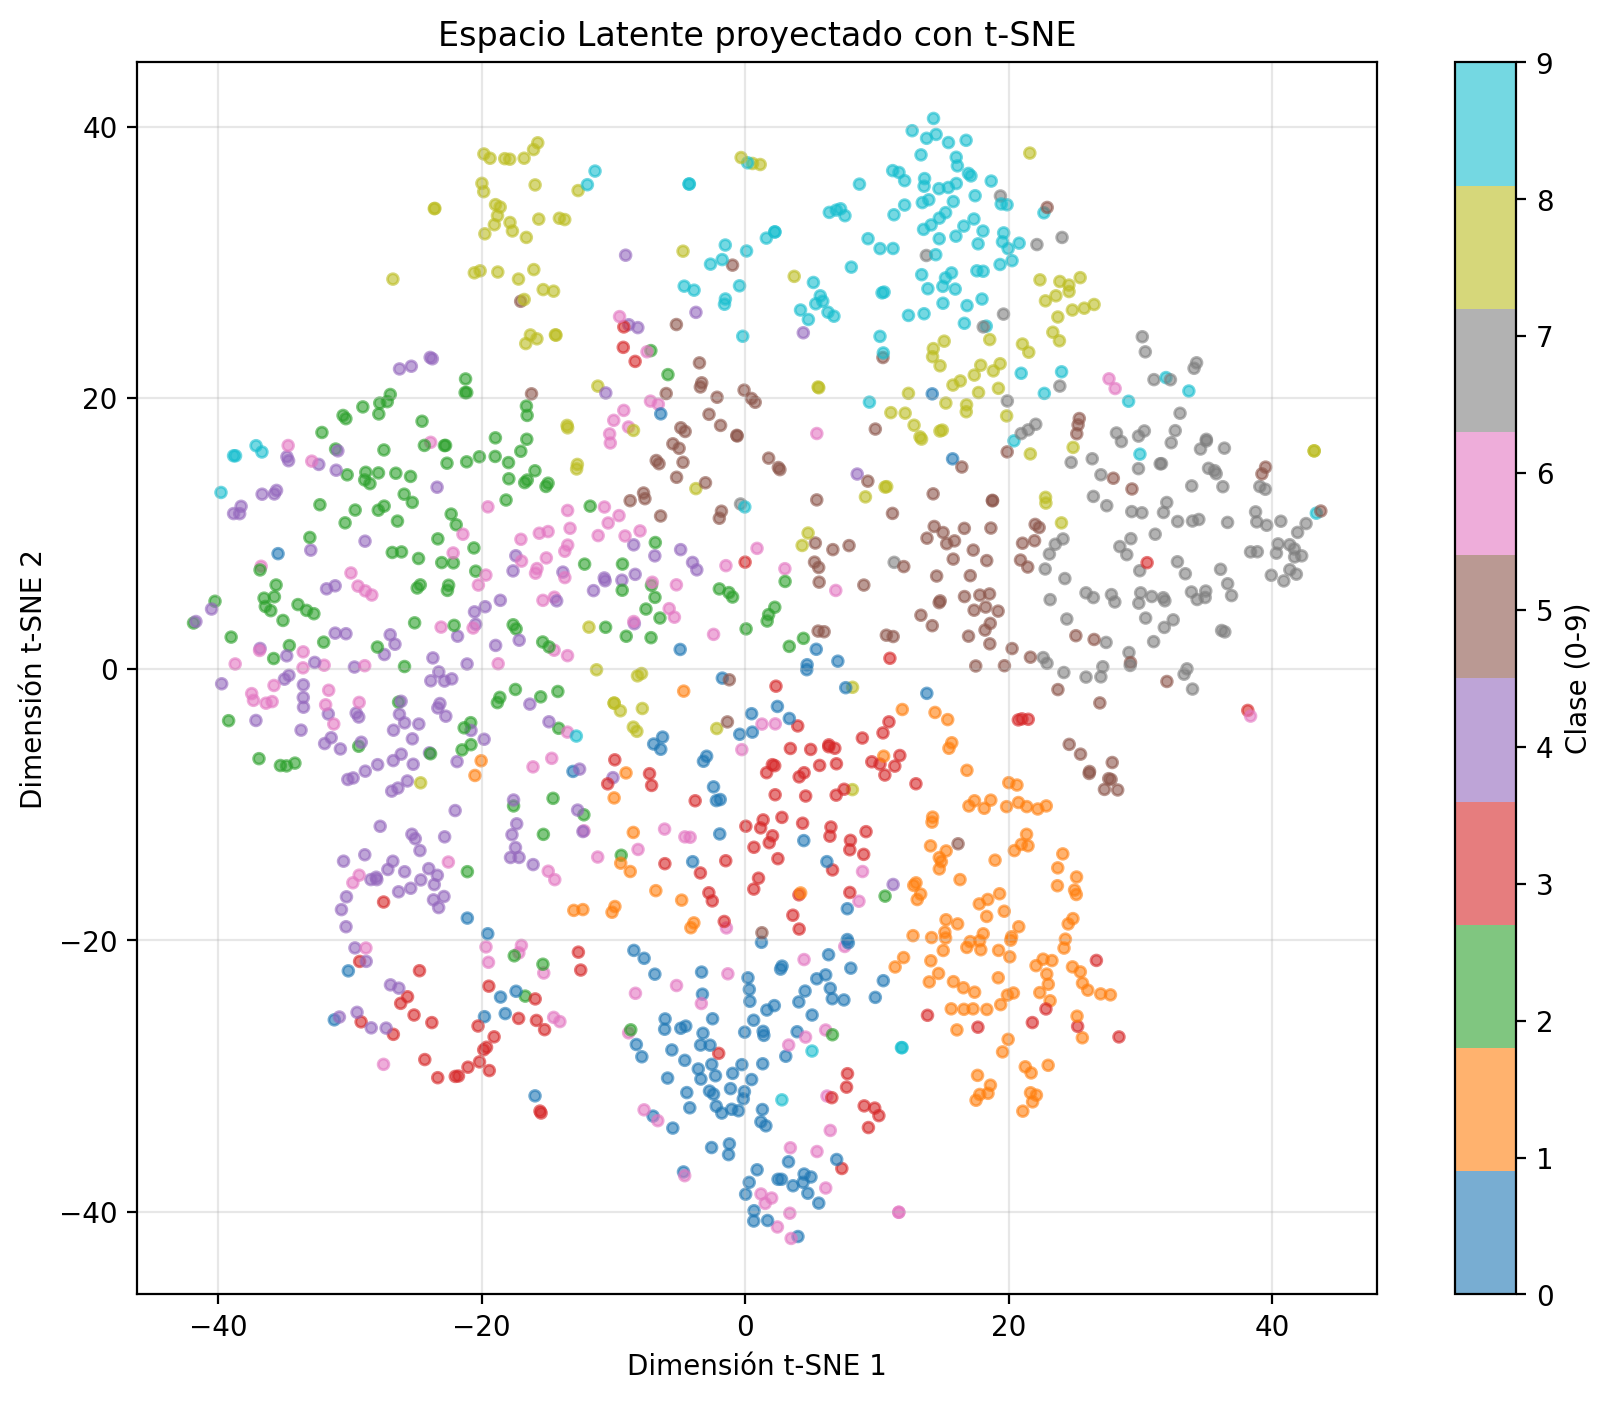

In [ ]:
#### BLOQUE DE VISUALIZACIÓN t-SNE ####

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Aseguramos que el modelo está en modo evaluación y en el dispositivo correcto
cvae.eval()
cvae.to(device)

# 1. Inicialización de listas de almacenamiento
latents = []
labels_list = []
num_batches_tsne = 20 # Limitamos a 20 batches para acelerar t-SNE

# 2. Obtener los vectores latentes de los datos
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        if i >= num_batches_tsne: break

        x = x.to(device)

        # Usamos el encoder (agnóstico, q(z|x)) para obtener la media (mu)
        # La función encode_and_sample devuelve mu, var, sample
        mu, _, _ = cvae.encoder.encode_and_sample(x)

        latents.append(mu.cpu().numpy())
        labels_list.append(y.numpy())

latents = np.concatenate(latents, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

# 3. Calcular t-SNE (Reducir a 2D)
print(f"Calculando t-SNE sobre {len(latents)} puntos...")
tsne = TSNE(n_components=2, random_state=42)
z_embedded = tsne.fit_transform(latents)

# 4. Graficar
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_embedded[:, 0], z_embedded[:, 1],
                      c=labels_list,
                      cmap='tab10', # Mapa de colores para las 10 clases
                      alpha=0.6,
                      s=15)

plt.colorbar(scatter, label='Clase (0-9)')
plt.title("Espacio Latente proyectado con t-SNE")
plt.xlabel("Dimensión t-SNE 1")
plt.ylabel("Dimensión t-SNE 2")
plt.grid(True, alpha=0.3)
plt.show()

### **2. IMPLEMENTACIÓN DE LA CVAE CON PRIOR APRENDIBLE**

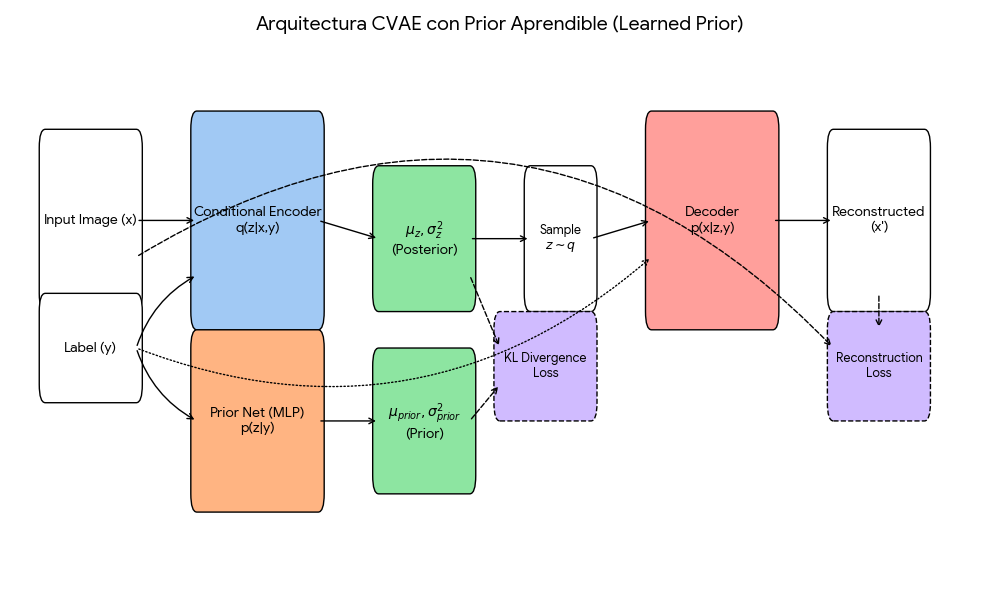

In [ ]:
# --- 1. NUEVA RED: Prior Network ---
class PriorNetwork(nn.Module):
    def __init__(self, dimz, num_classes=10, embed_dim=10):
        """
        Red pequeña que aprende la distribución a priori p(z|y).
        Input: Label y
        Output: Media y Varianza del prior para esa clase.
        """
        super().__init__()
        self.dimz = dimz

        # Usamos embedding para la etiqueta
        self.embed = nn.Embedding(num_classes, embed_dim)

        # MLP simple: Embedding -> Hidden -> Salida
        self.fc1 = nn.Linear(embed_dim, 32)
        self.relu = nn.ReLU()

        # Salida: dimz (medias) + dimz (varianzas)
        self.fc2 = nn.Linear(32, dimz * 2)
        self.softplus = nn.Softplus()

    def forward(self, labels):
        y = self.embed(labels)
        h = self.relu(self.fc1(y))
        out = self.fc2(h)

        # Dividir en media y varianza
        mu_prior = out[:, :self.dimz]
        # Usamos softplus para asegurar varianza positiva
        var_prior = self.softplus(out[:, self.dimz:]) + 1e-6 # Epsilon por seguridad

        return mu_prior, var_prior

# --- 2. ENCODER CONDICIONAL ---
class ConditionalEncoder(nn.Module):
    def __init__(self, dimz, num_classes=10, embed_dim=10, channels=1):
        super().__init__()
        self.dimz = dimz
        self.embed = nn.Embedding(num_classes, embed_dim)

        # Arquitectura igual que antes
        self.conv1 = nn.Conv2d(channels, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 32, 4, 2, 1)
        self.conv3 = nn.Conv2d(32, 64, 4, 2, 1)
        self.conv4 = nn.Conv2d(64, 256, 4, 2, 1)
        self.relu = nn.ReLU()

        # Linear: 256 (imagen) + embed_dim (etiqueta) -> dimz*2
        self.linear = nn.Linear(256 + embed_dim, dimz * 2)
        self.softplus = nn.Softplus()

    def forward(self, x, labels):
        # Procesar imagen
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x_flat = x.view(x.size(0), -1) # (Batch, 256)

        # Procesar etiqueta
        y_emb = self.embed(labels)     # (Batch, embed_dim)

        # Concatenar
        inputs = torch.cat([x_flat, y_emb], dim=1)

        # Predecir parámetros q(z|x,y)
        z_params = self.linear(inputs)
        return z_params

    def encode_and_sample(self, x, labels):
        """
        Calcula media y varianza del espacio latente y genera una muestra
        usando el truco de reparametrización.
        """
        z_params = self.forward(x, labels)
        mu = z_params[:, :self.dimz]
        var = self.softplus(0.5 * z_params[:, self.dimz:]) + 1e-6

        eps = torch.randn_like(var)
        sample = mu + eps * torch.sqrt(var)
        return mu, var, sample

In [ ]:
# --- 3. CLASE CVAE CON PRIOR APRENDIBLE ---
class CVAE_LearnedPrior(nn.Module):
    def __init__(self, dimz, num_classes=10, embed_dim=10, channels=1, var_x=0.1):
        super().__init__()
        self.dimz = dimz
        self.var_x = var_x

        # 1. Prior Network p(z|y)
        self.prior_net = PriorNetwork(dimz, num_classes, embed_dim)

        # 2. Encoder q(z|x, y)
        self.encoder = ConditionalEncoder(dimz, num_classes, embed_dim, channels)

        # 3. Decoder p(x|z, y) (Usamos la clase decoder que ya tenías, no cambia)
        # Nota: Asegúrate de tener la clase 'decoder' definida en tu notebook
        self.decoder = decoder(dimz, num_classes, embed_dim, channels)

    def forward(self, x, labels):
        # A. Encoder: q(z | x, y)
        mu_z, var_z, sample_z = self.encoder.encode_and_sample(x, labels)

        # B. Prior: p(z | y)
        mu_prior, var_prior = self.prior_net(labels)

        # C. Decoder: p(x | z, y)
        mu_x = self.decoder.decode(sample_z, labels)

        # Devolvemos todo lo necesario para la loss
        return mu_x, mu_z, var_z, mu_prior, var_prior

    def loss_function(self, x, mu_x, mu_z, var_z, mu_prior, var_prior):
        """
        Loss con KL Generalizada entre dos Gaussianas.
        """
        # 1. Log-Likelihood (Reconstrucción) - Igual que siempre
        # Usamos tu función auxiliar 'eval_Gaussian_LL'
        logp, _ = eval_Gaussian_LL(x, mu_x, self.var_x)

        # 2. KL Divergence Generalizada
        # KL( q(z|x,y) || p(z|y) )
        # q = N(mu_z, var_z)      [Posterior]
        # p = N(mu_prior, var_prior) [Prior]

        # Formula: 0.5 * [ log(var_p / var_q) - 1 + (var_q / var_p) + (mu_q - mu_p)^2 / var_p ]

        term1 = torch.log(var_prior) - torch.log(var_z)
        term2 = var_z / var_prior
        term3 = (mu_z - mu_prior).pow(2) / var_prior

        kl_element_wise = 0.5 * (term1 - 1 + term2 + term3)
        KL = torch.sum(kl_element_wise) # Suma sobre batch y dimensiones

        # Total Loss
        total_loss = -logp + KL

        return total_loss, -logp, KL

In [ ]:
class CVAE_LearnedPrior_Extended(CVAE_LearnedPrior):

    def __init__(self, dimz, num_classes=10, embed_dim=10, channels=1, var_x=0.1,
                 lr=1e-3, epochs=20):

        # 1. Inicializamos la arquitectura (Encoder + Decoder + PriorNet)
        super().__init__(dimz, num_classes, embed_dim, channels, var_x)

        # 2. Configuración de entrenamiento
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        # Dispositivo
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        # Historial para gráficas (Train)
        self.loss_history = []
        self.recon_history = []
        self.kl_history = []

        # Historial para gráficas (Validation)
        self.val_loss_history = []
        self.val_recon_history = []
        self.val_kl_history = []

    def trainloop(self, trainloader, valloader):
        print(f"Iniciando entrenamiento (Prior Aprendible) en: {self.device}")

        for e in range(int(self.epochs)):
            # --- FASE 1: ENTRENAMIENTO ---
            self.train()
            train_loss, train_rec, train_kl = 0, 0, 0

            for x, y in trainloader:
                x, y = x.to(self.device), y.to(self.device)

                self.optim.zero_grad()

                # Forward (Devuelve 5 cosas en este modelo)
                mu_x, mu_z, var_z, mu_prior, var_prior = self.forward(x, y)

                # Loss (Recibe 6 argumentos)
                loss, rec, kl = self.loss_function(x, mu_x, mu_z, var_z, mu_prior, var_prior)

                loss.backward()
                self.optim.step()

                train_loss += loss.item()
                train_rec += rec.item()
                train_kl += kl.item()

            # --- FASE 2: VALIDACIÓN ---
            self.eval()
            val_loss, val_rec, val_kl = 0, 0, 0

            with torch.no_grad():
                for x, y in valloader:
                    x, y = x.to(self.device), y.to(self.device)

                    # Forward y Loss (Igual que train, 5 retornos)
                    mu_x, mu_z, var_z, mu_prior, var_prior = self.forward(x, y)
                    loss, rec, kl = self.loss_function(x, mu_x, mu_z, var_z, mu_prior, var_prior)

                    val_loss += loss.item(); val_rec += rec.item(); val_kl += kl.item()

            # --- GUARDAR MÉTRICAS ---
            n_train = len(trainloader)
            n_val = len(valloader)

            # Train
            self.loss_history.append(train_loss / n_train)
            self.recon_history.append(train_rec / n_train)
            self.kl_history.append(train_kl / n_train)

            # Val
            self.val_loss_history.append(val_loss / n_val)
            self.val_recon_history.append(val_rec / n_val)
            self.val_kl_history.append(val_kl / n_val)

            # Imprimir progreso detallado
            print(f'Epoch {e+1:2d} | '
                  f'Train [Loss: {self.loss_history[-1]:.1f} | Rec: {self.recon_history[-1]:.1f} | KL: {self.kl_history[-1]:.1f}] | '
                  f'Val [Loss: {self.val_loss_history[-1]:.1f} | Rec: {self.val_recon_history[-1]:.1f} | KL: {self.val_kl_history[-1]:.1f}]')

    def sample(self, num_imgs, label_idx=None):
        """
        Generación de nuevas muestras usando el Prior Aprendido (MLP).
        NO usa el encoder. Usa la MLP para saber dónde muestrear.
        """
        self.eval()
        with torch.no_grad():

            # 1. Gestionar etiquetas
            if label_idx is not None:
                # Si pedimos una clase específica (ej. 7)
                labels = torch.full((num_imgs,), label_idx, dtype=torch.long).to(self.device)
            else:
                # Si no, clases aleatorias
                labels = torch.randint(0, 10, (num_imgs,)).to(self.device)

            # 2. PREGUNTAR A LA MLP (Prior Net)
            # "¿Dónde están los centros y varianzas para estas clases?"
            mu_prior, var_prior = self.prior_net(labels)

            # 3. MUESTREAR Z
            # Usamos la distribución que nos ha dado la MLP
            eps = torch.randn_like(var_prior)
            z_sample = mu_prior + eps * torch.sqrt(var_prior)

            # 4. DECODIFICAR
            x_recon = self.decoder.decode(z_sample, labels)

            return x_recon.cpu()

In [ ]:
# 1. Instanciar
model = CVAE_LearnedPrior_Extended(
    dimz=16,
    num_classes=10,
    embed_dim=10,
    channels=1,
    var_x=0.1,
    lr=1e-3,
    epochs=50
)

# 2. Entrenar
model.trainloop(train_loader, test_loader)



Iniciando entrenamiento (Prior Aprendible) en: cuda
Epoch  1 | Train [Loss: 21574.3 | Rec: 20182.9 | KL: 1391.4] | Val [Loss: 10356.6 | Rec: 8921.3 | KL: 1435.3]
Epoch  2 | Train [Loss: 8239.4 | Rec: 6843.5 | KL: 1395.9] | Val [Loss: 6925.9 | Rec: 5509.0 | KL: 1416.9]
Epoch  3 | Train [Loss: 5911.2 | Rec: 4450.6 | KL: 1460.6] | Val [Loss: 6622.0 | Rec: 5134.2 | KL: 1487.8]
Epoch  4 | Train [Loss: 4535.8 | Rec: 3003.8 | KL: 1532.1] | Val [Loss: 4569.7 | Rec: 3030.8 | KL: 1538.9]
Epoch  5 | Train [Loss: 3710.9 | Rec: 2148.4 | KL: 1562.5] | Val [Loss: 3682.3 | Rec: 2142.8 | KL: 1539.5]
Epoch  6 | Train [Loss: 3138.2 | Rec: 1553.4 | KL: 1584.8] | Val [Loss: 2995.0 | Rec: 1374.7 | KL: 1620.3]
Epoch  7 | Train [Loss: 2687.6 | Rec: 1068.9 | KL: 1618.6] | Val [Loss: 2709.8 | Rec: 1088.1 | KL: 1621.7]
Epoch  8 | Train [Loss: 2333.3 | Rec: 685.7 | KL: 1647.6] | Val [Loss: 2316.9 | Rec: 660.8 | KL: 1656.2]
Epoch  9 | Train [Loss: 2047.8 | Rec: 371.3 | KL: 1676.5] | Val [Loss: 2231.8 | Rec: 549.8 

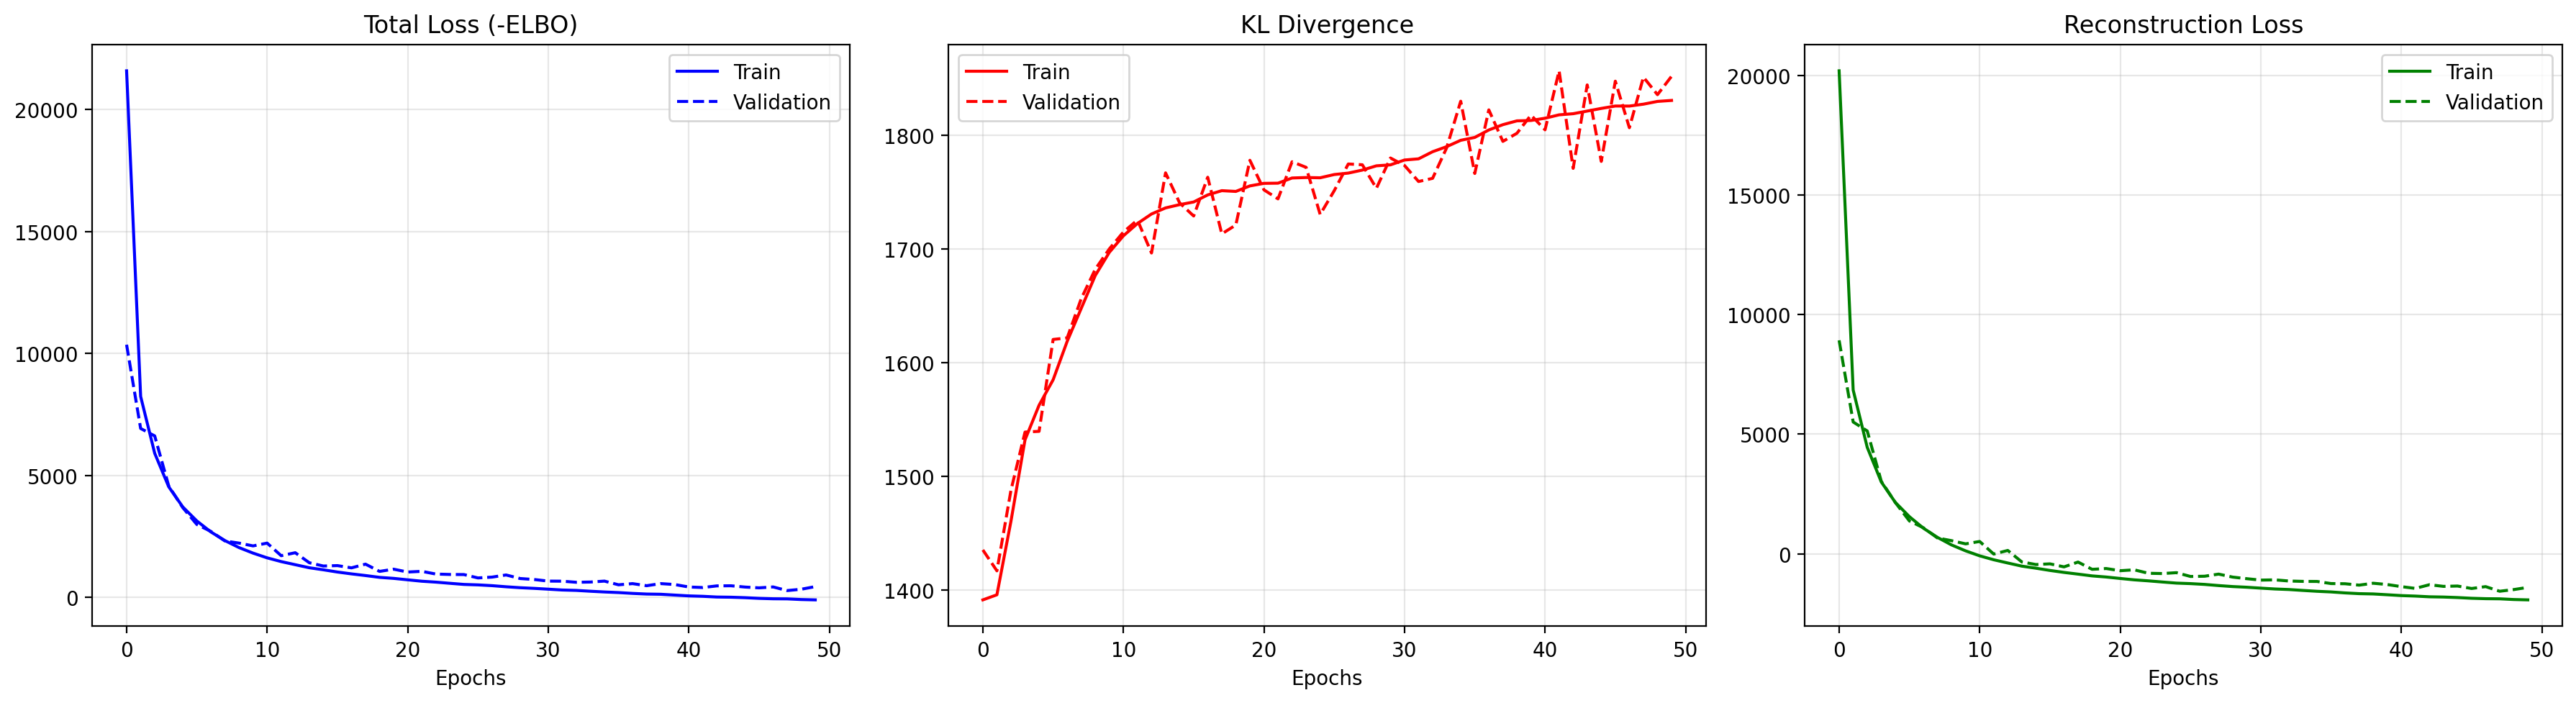

In [ ]:
# Empaquetamos los historiales de Entrenamiento y Validación
history_dict = {
    # Train
    'loss': model.loss_history,
    'kl': model.kl_history,
    'recon': model.recon_history,

    # Validation (Nuevos)
    'val_loss': model.val_loss_history,
    'val_kl': model.val_kl_history,
    'val_recon': model.val_recon_history
}

# Llamamos a la función
plot_metrics(history_dict)

#### **2.2 Visualización de la Generación y el Espacio Latente**

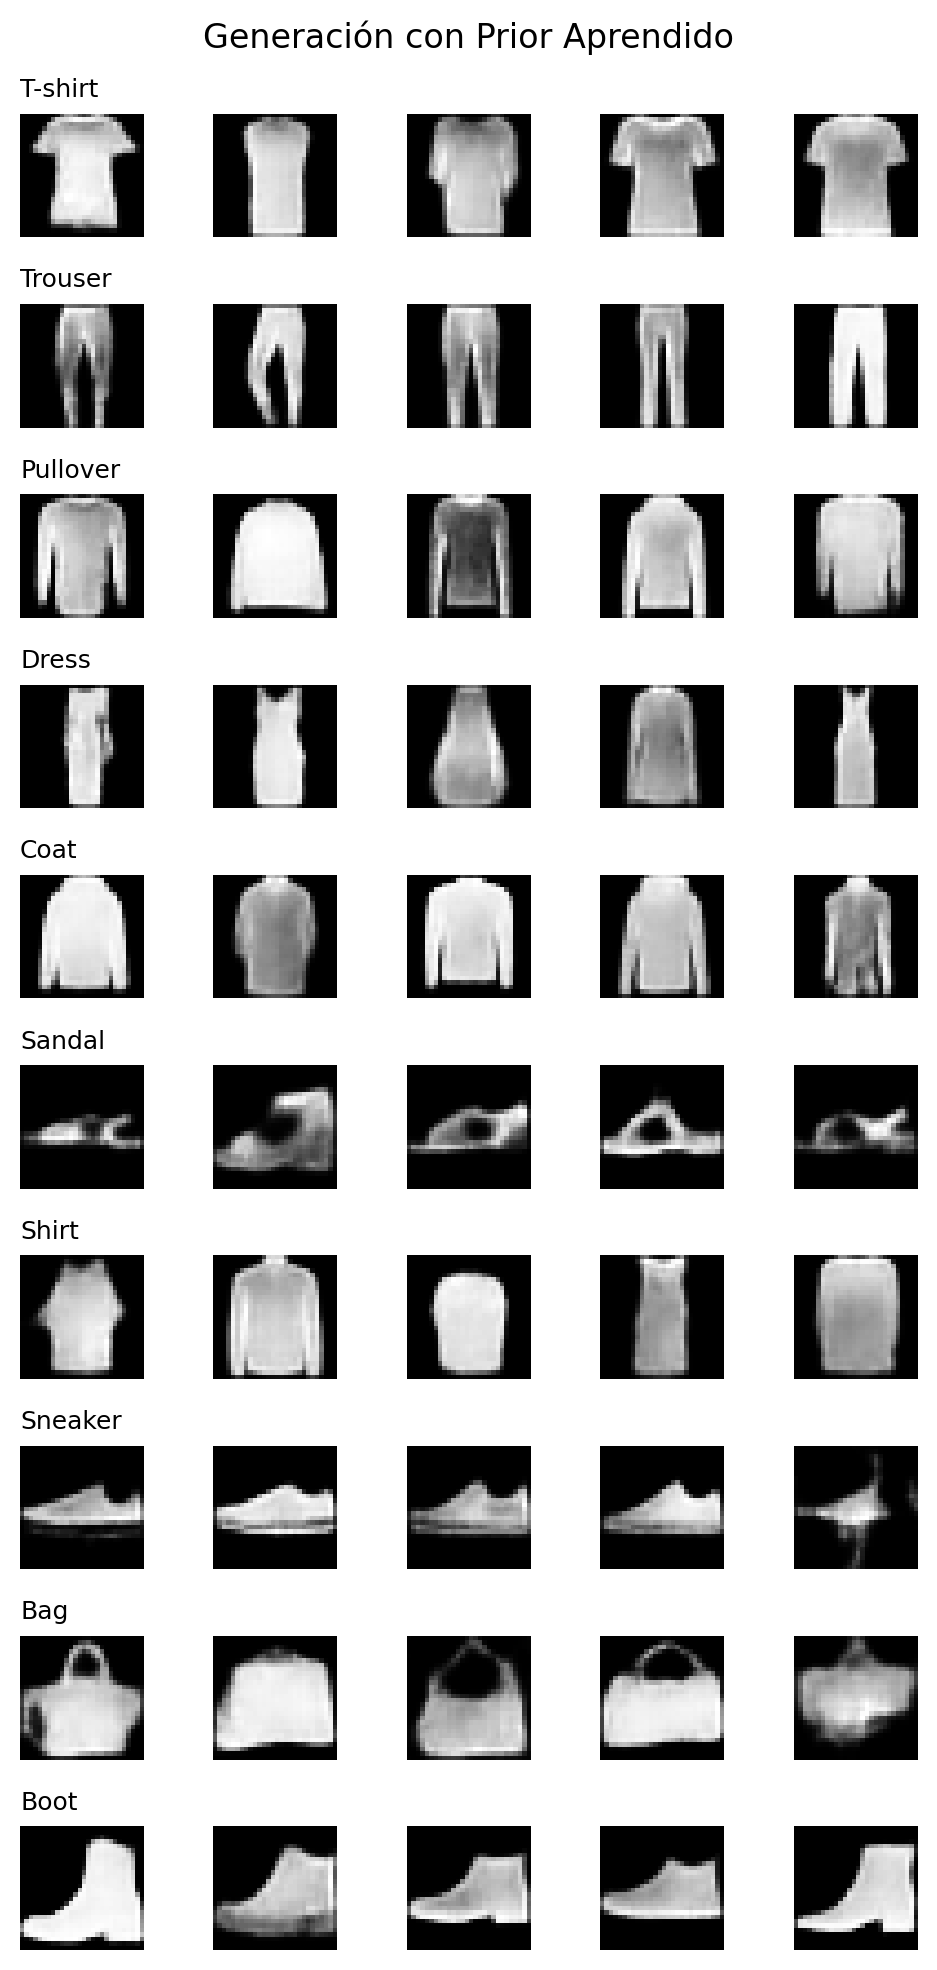

In [ ]:
# Llama a la función pasando tu modelo
visualize_generation(model, num_samples=5, title="Generación con Prior Aprendido")

Calculando t-SNE sobre 1280 puntos...


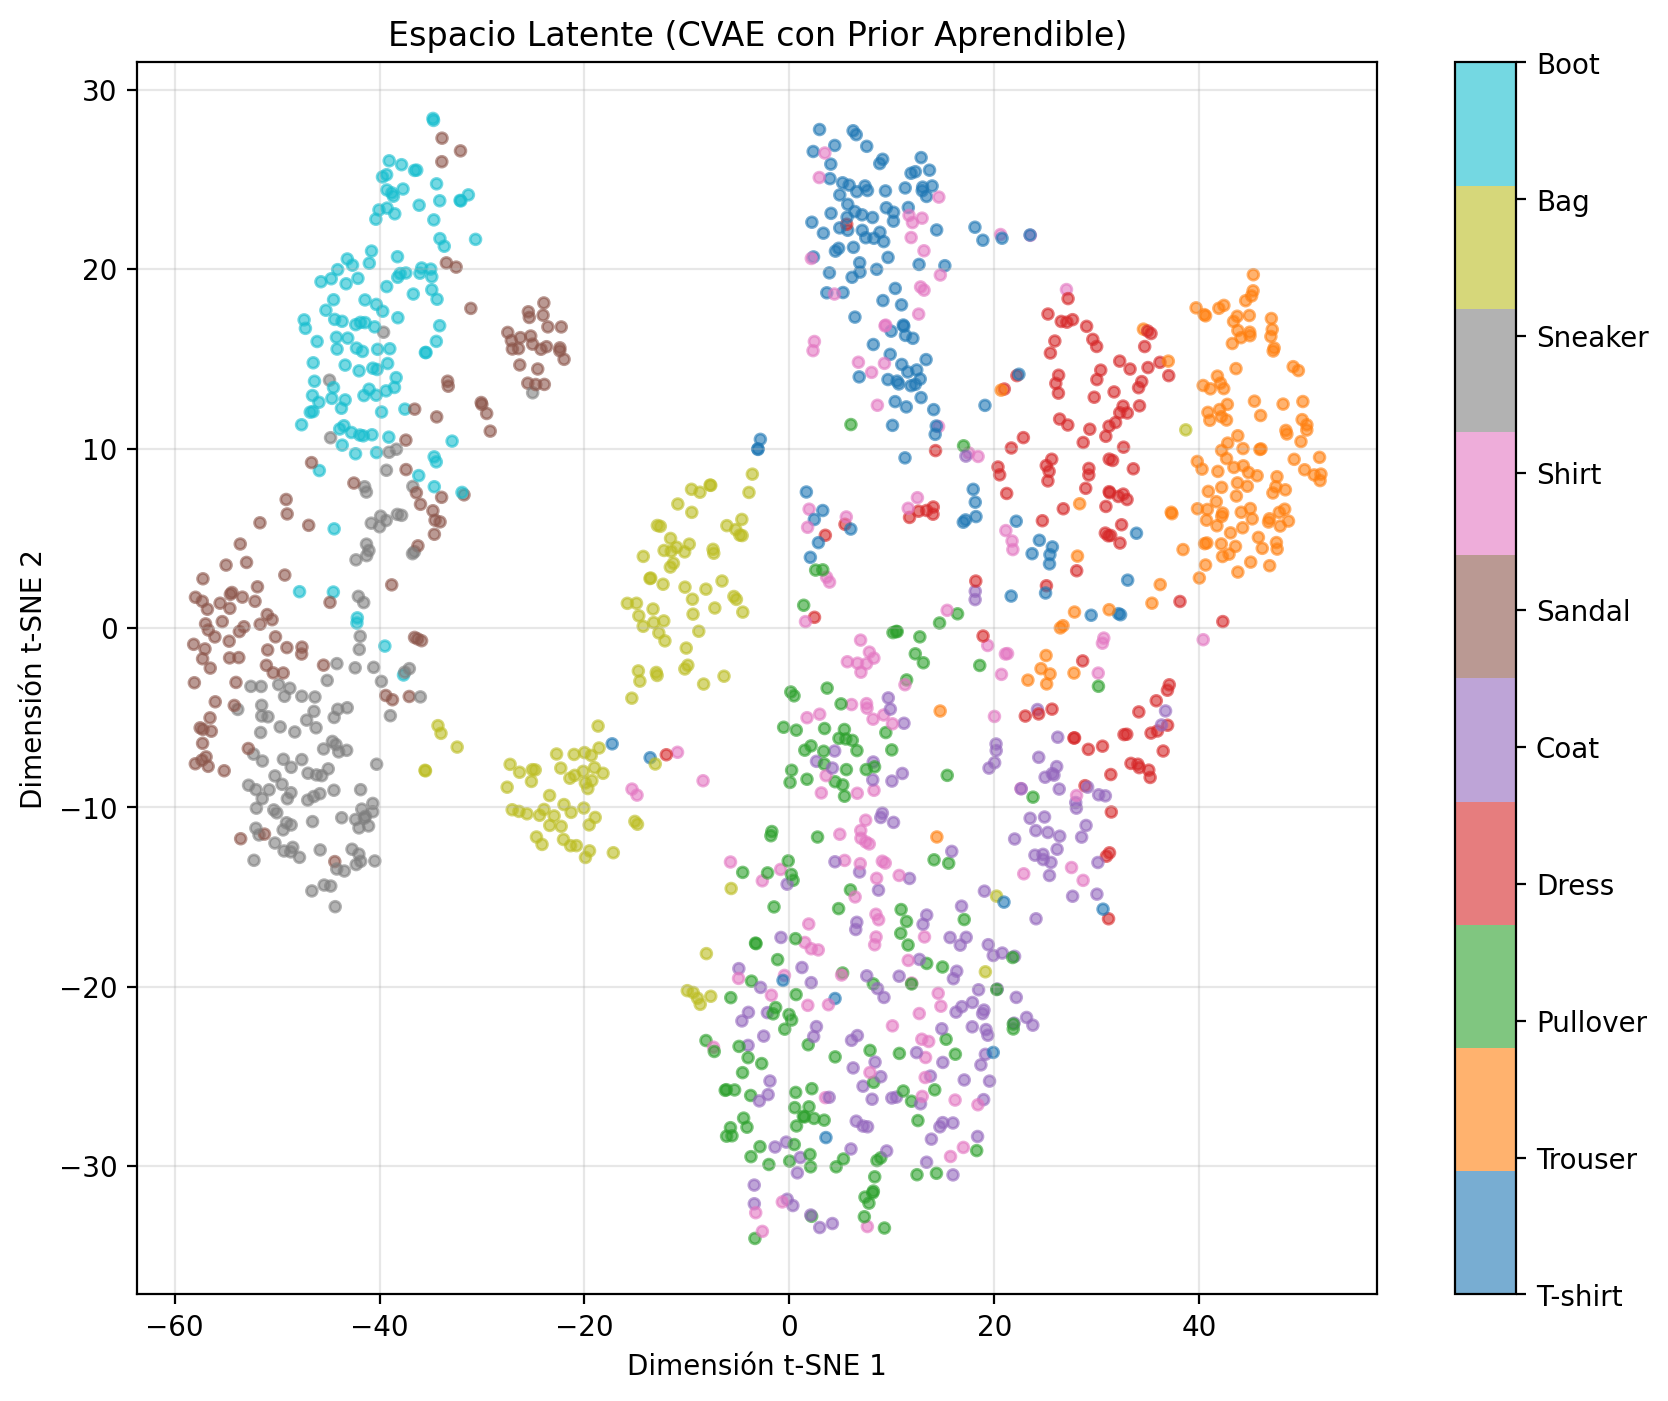

In [ ]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 1. Inicialización
latents = []
labels_list = []
num_batches_tsne = 20

# 2. Obtener los vectores latentes
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        if i >= num_batches_tsne: break

        x = x.to(device)
        y = y.to(device)

        # Usamos el encoder CONDICIONAL q(z|x, y) para obtener la media (mu)
        # <--- CAMBIO 2: Pasar 'y' al encoder
        mu, _, _ = model.encoder.encode_and_sample(x, y)

        latents.append(mu.cpu().numpy())
        labels_list.append(y.cpu().numpy()) # Aseguramos volver a CPU para numpy

latents = np.concatenate(latents, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

# 3. Calcular t-SNE
print(f"Calculando t-SNE sobre {len(latents)} puntos...")
tsne = TSNE(n_components=2, random_state=42)
z_embedded = tsne.fit_transform(latents)

# 4. Graficar
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_embedded[:, 0], z_embedded[:, 1],
                      c=labels_list,
                      cmap='tab10',
                      alpha=0.6,
                      s=15)

# Crear una barra de color con los nombres reales para mayor claridad
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.ax.set_yticklabels(['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot'])

plt.title("Espacio Latente (CVAE con Prior Aprendible)")
plt.xlabel("Dimensión t-SNE 1")
plt.ylabel("Dimensión t-SNE 2")
plt.grid(True, alpha=0.3)
plt.show()

### **4. IMPLENTACIÓN DE UNA CGAN**

Se ha optado por implementar una CGAN con arquitectura Wasserstein  para mayor estabilidad en el entrenamiento



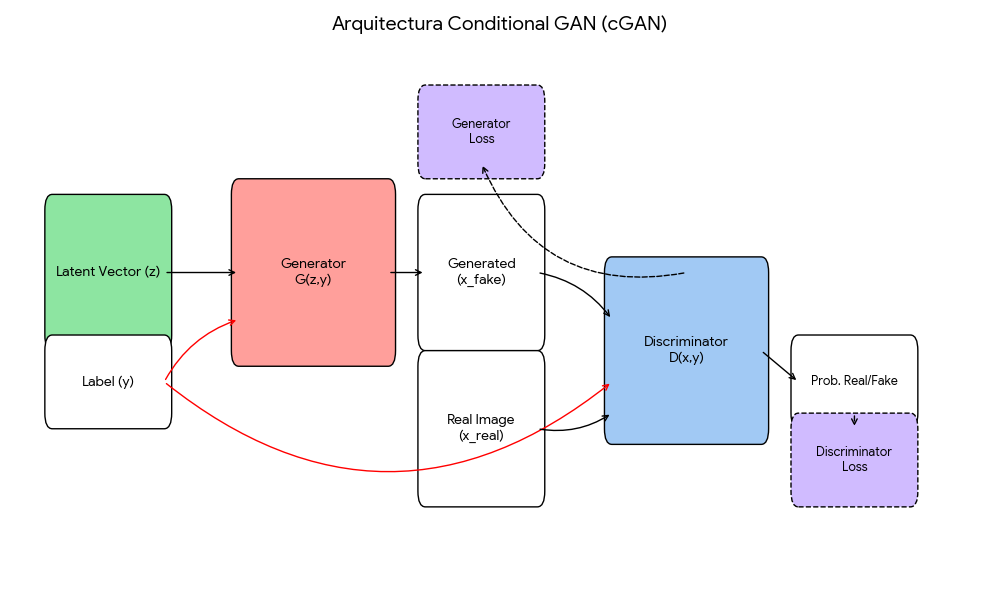

In [ ]:
# --- Configuración ---
workers = 2
batch_size = 128
image_size = 64
nc = 1           # Canales de la imagen (Grayscale)
nz = 100         # Tamaño vector latente z
ngf = 64         # Feature maps del generador
ndf = 64         # Feature maps del discriminador
num_epochs = 50
#lr = 0.0002      # DCGAN suele funcionar mejor con 0.0002 que con 0.005
lr=0.005
beta1 = 0.5
ngpu = 1
num_classes = 10 # Fashion MNIST tiene 10 clases
embed_dim = 10   # Dimensión del embedding para el Generador

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# --- Preparación de Datos ---
# Redimensionar a 64x64 para que coincida con la arquitectura DCGAN
dataset = datasets.FashionMNIST(root='./data', train=True, download=True,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                            ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 181kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.32MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 30.5MB/s]


In [ ]:
# Función personalizada de inicialización de pesos
def weights_init(m):
    classname = m.__class__.__name__

    # Inicialización para capas Conv2d y ConvTranspose2d
    if classname.find('Conv') != -1:
        # Los pesos se inicializan con una distribución Normal
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    # Inicialización para capas BatchNorm2d
    elif classname.find('BatchNorm') != -1:
        # Los pesos (gamma) se inicializan con una distribución Normal centrada en 1.0
        nn.init.normal_(m.weight.data, 1.0, 0.02)

        # Los sesgos (beta) se inicializan a cero
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# --- Generador Condicional ---
class ConditionalGenerator(nn.Module):
    def __init__(self, ngpu):
        super(ConditionalGenerator, self).__init__()
        self.ngpu = ngpu

        # Capa de embedding para las etiquetas: convierte un entero en un vector denso
        self.label_emb = nn.Embedding(num_classes, embed_dim)

        # La entrada ahora es nz + embed_dim (ruido + etiqueta)
        self.main = nn.Sequential(
            # input  Z + Label
            nn.ConvTranspose2d(nz + embed_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, z, labels):
        # 1. Crear el embedding de la etiqueta
        c = self.label_emb(labels) # [Batch, embed_dim]
        # 2. Concatenar ruido y etiqueta
        x = torch.cat([z, c], 1)   # [Batch, nz + embed_dim]
        # 3. Redimensionar para que entre en la ConvTranspose (Batch, Canales, 1, 1)
        x = x.view(x.size(0), -1, 1, 1)
        return self.main(x)

In [ ]:
# --- Discriminador Condicional (WGAN-GP) ---
class ConditionalDiscriminator(nn.Module):
    def __init__(self, ngpu):
        super(ConditionalDiscriminator, self).__init__()
        self.ngpu = ngpu

        # Embedding para el discriminador.
        self.label_emb = nn.Embedding(num_classes, image_size * image_size)

        # La entrada tiene (nc + 1) canales: Imagen original + Canal de etiqueta
        self.main = nn.Sequential(
            # input is (nc + 1) x 64 x 64
            # Capa 1: No suele llevar normalización
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf) x 32 x 32
            # Capa 2: Cambio de BatchNorm2d -> InstanceNorm2d
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*2) x 16 x 16
            # Capa 3: Cambio de BatchNorm2d -> InstanceNorm2d
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            # Capa 4: Cambio de BatchNorm2d -> InstanceNorm2d
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*8) x 4 x 4
            # Salida: Escalar sin función de activación (Sin Sigmoid para WGAN)
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, img, labels):
        # 1. Crear embedding de etiqueta y redimensionar a imagen (Batch, 1, 64, 64)
        c = self.label_emb(labels)
        c = c.view(-1, 1, image_size, image_size)

        # 2. Concatenar la imagen y la "imagen de etiqueta" por el canal
        x = torch.cat([img, c], 1)

        return self.main(x)


In [ ]:
# --- Instanciar Modelos ---
netG = ConditionalGenerator(ngpu).to(device)
netG.apply(weights_init)

netD = ConditionalDiscriminator(ngpu).to(device)
netD.apply(weights_init)

ConditionalDiscriminator(
  (label_emb): Embedding(10, 4096)
  (main): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False

In [ ]:
# --- WGAN-GP: parámetros sugeridos ---
lr = 1e-4
beta1 = 0.0
beta2 = 0.9
n_critic = 5
lambda_gp = 10.0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))


In [ ]:
# función de penalización de gradiente
def gradient_penalty(critic, real_imgs, fake_imgs, labels, device):
    alpha = torch.rand(real_imgs.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
    d_interpolates = critic(interpolates, labels)

    d_interpolates = d_interpolates.view(-1)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size(), device=device),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    grad_norm = gradients.norm(2, dim=1)
    gp = ((grad_norm - 1) ** 2).mean()
    return gp

In [ ]:
num_epochs= 30

# --- Listas para guardar la evolución ---
G_losses = []
D_losses = []

print("Iniciando entrenamiento WGAN...")

print("Iniciando entrenamiento WGAN-GP...")

for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(dataloader):
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        labels = labels.to(device).long()

        # --- (1) Update critic n_critic times ---
        netD.zero_grad()
        noise = torch.randn(b_size, nz, device=device)
        fake_labels = torch.randint(0, num_classes, (b_size,), device=device, dtype=torch.long)
        fake = netG(noise, fake_labels).detach()

        output_real = netD(real_cpu, labels).view(-1)
        output_fake = netD(fake, fake_labels).view(-1)

        errD = torch.mean(output_fake) - torch.mean(output_real)
        # gradient penalty
        gp = gradient_penalty(netD, real_cpu, fake, labels, device)
        errD_total = errD + lambda_gp * gp

        errD_total.backward()
        optimizerD.step()

        # --- (2) Update generator every n_critic steps ---
        if i % n_critic == 0:
            netG.zero_grad()
            noise2 = torch.randn(b_size, nz, device=device)
            fake_labels2 = torch.randint(0, num_classes, (b_size,), device=device, dtype=torch.long)
            fake2 = netG(noise2, fake_labels2)
            output = netD(fake2, fake_labels2).view(-1)
            errG = -torch.mean(output)
            errG.backward()
            optimizerG.step()

            G_losses.append(errG.item())
            D_losses.append(errD.item())

        if i % 100 == 0:
            eg = f"{errG.item():.4f}" if (i % n_critic == 0) else "----"
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item():.4f} GP: {gp.item():.4f} Loss_G: {eg}')

Iniciando entrenamiento WGAN...
Iniciando entrenamiento WGAN-GP...
[0/30][0/469] Loss_D: 0.4746 GP: 0.6132 Loss_G: -0.2864
[0/30][100/469] Loss_D: -73.4908 GP: 2.0599 Loss_G: 47.1167
[0/30][200/469] Loss_D: -45.6664 GP: 0.9729 Loss_G: 37.4883
[0/30][300/469] Loss_D: -40.9762 GP: 0.9264 Loss_G: 33.4960
[0/30][400/469] Loss_D: -28.2686 GP: 0.5588 Loss_G: 30.3338
[1/30][0/469] Loss_D: -24.1203 GP: 0.5167 Loss_G: 28.4866
[1/30][100/469] Loss_D: -27.3960 GP: 0.3679 Loss_G: 28.0320
[1/30][200/469] Loss_D: -21.4355 GP: 0.4222 Loss_G: 30.0864
[1/30][300/469] Loss_D: -16.3336 GP: 0.2581 Loss_G: 36.3388
[1/30][400/469] Loss_D: -21.3379 GP: 0.3416 Loss_G: 38.0518
[2/30][0/469] Loss_D: -16.7729 GP: 0.3803 Loss_G: 38.6290
[2/30][100/469] Loss_D: -20.6421 GP: 0.3435 Loss_G: 36.1673
[2/30][200/469] Loss_D: -13.3474 GP: 0.4413 Loss_G: 44.5366
[2/30][300/469] Loss_D: -15.2249 GP: 0.2477 Loss_G: 38.9212
[2/30][400/469] Loss_D: -27.5627 GP: 0.3176 Loss_G: 44.0706
[3/30][0/469] Loss_D: -17.7229 GP: 0.4904

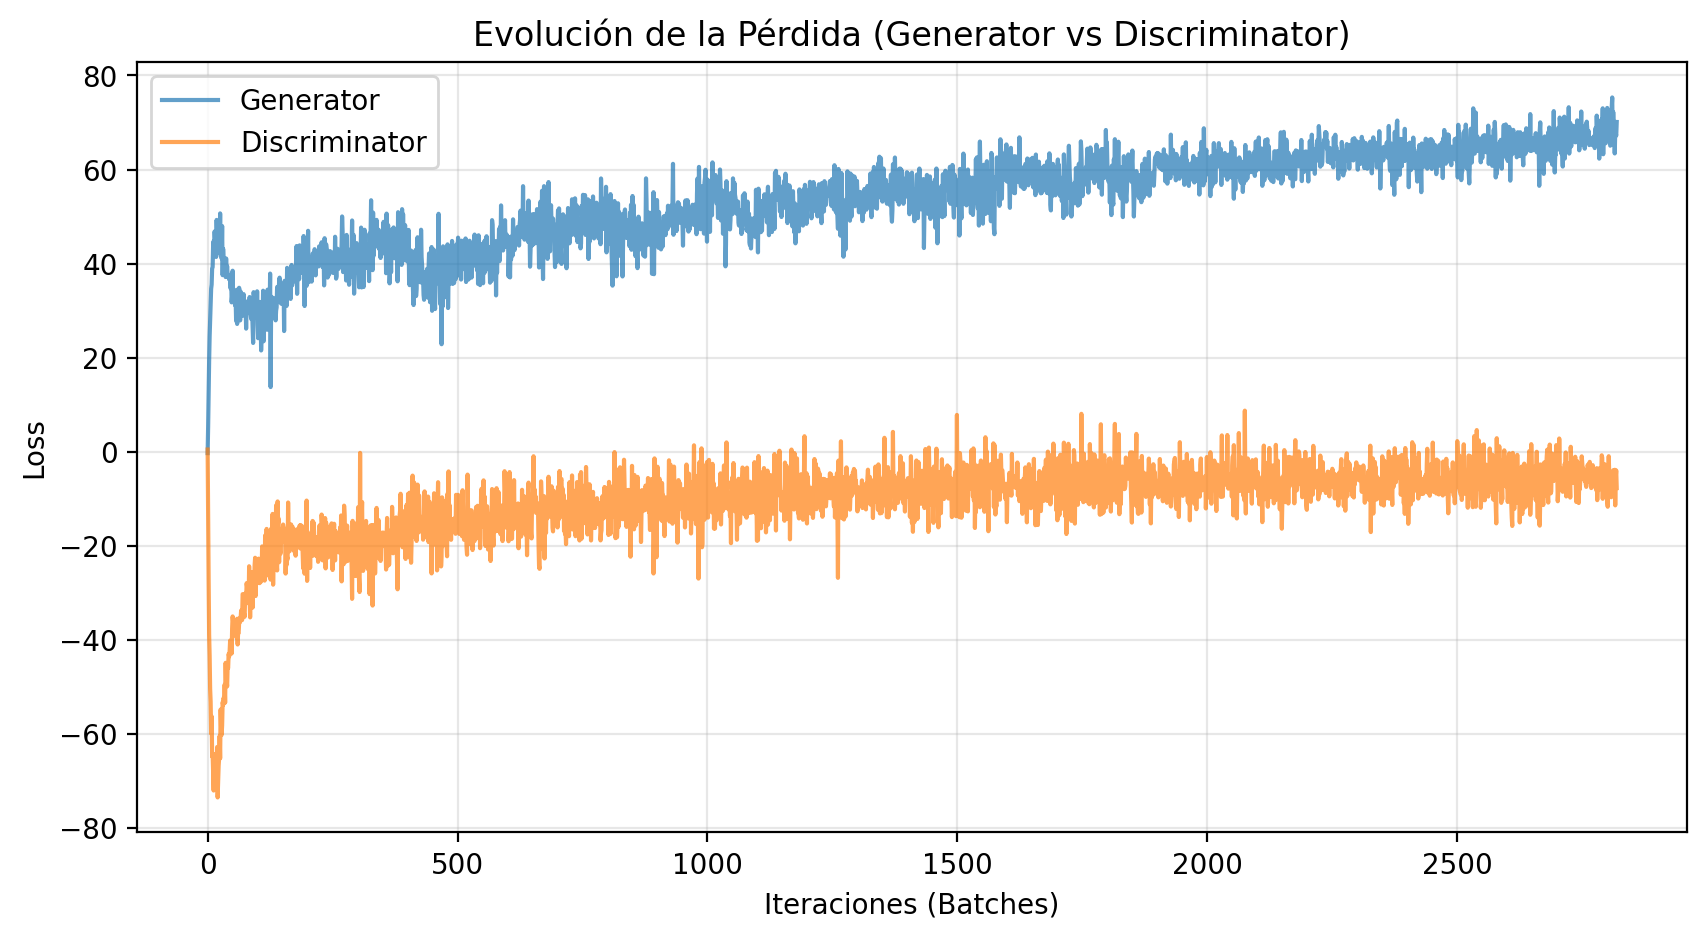

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Evolución de la Pérdida (Generator vs Discriminator)")
plt.plot(G_losses, label="Generator", alpha=0.7)
plt.plot(D_losses, label="Discriminator", alpha=0.7)
plt.xlabel("Iteraciones (Batches)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

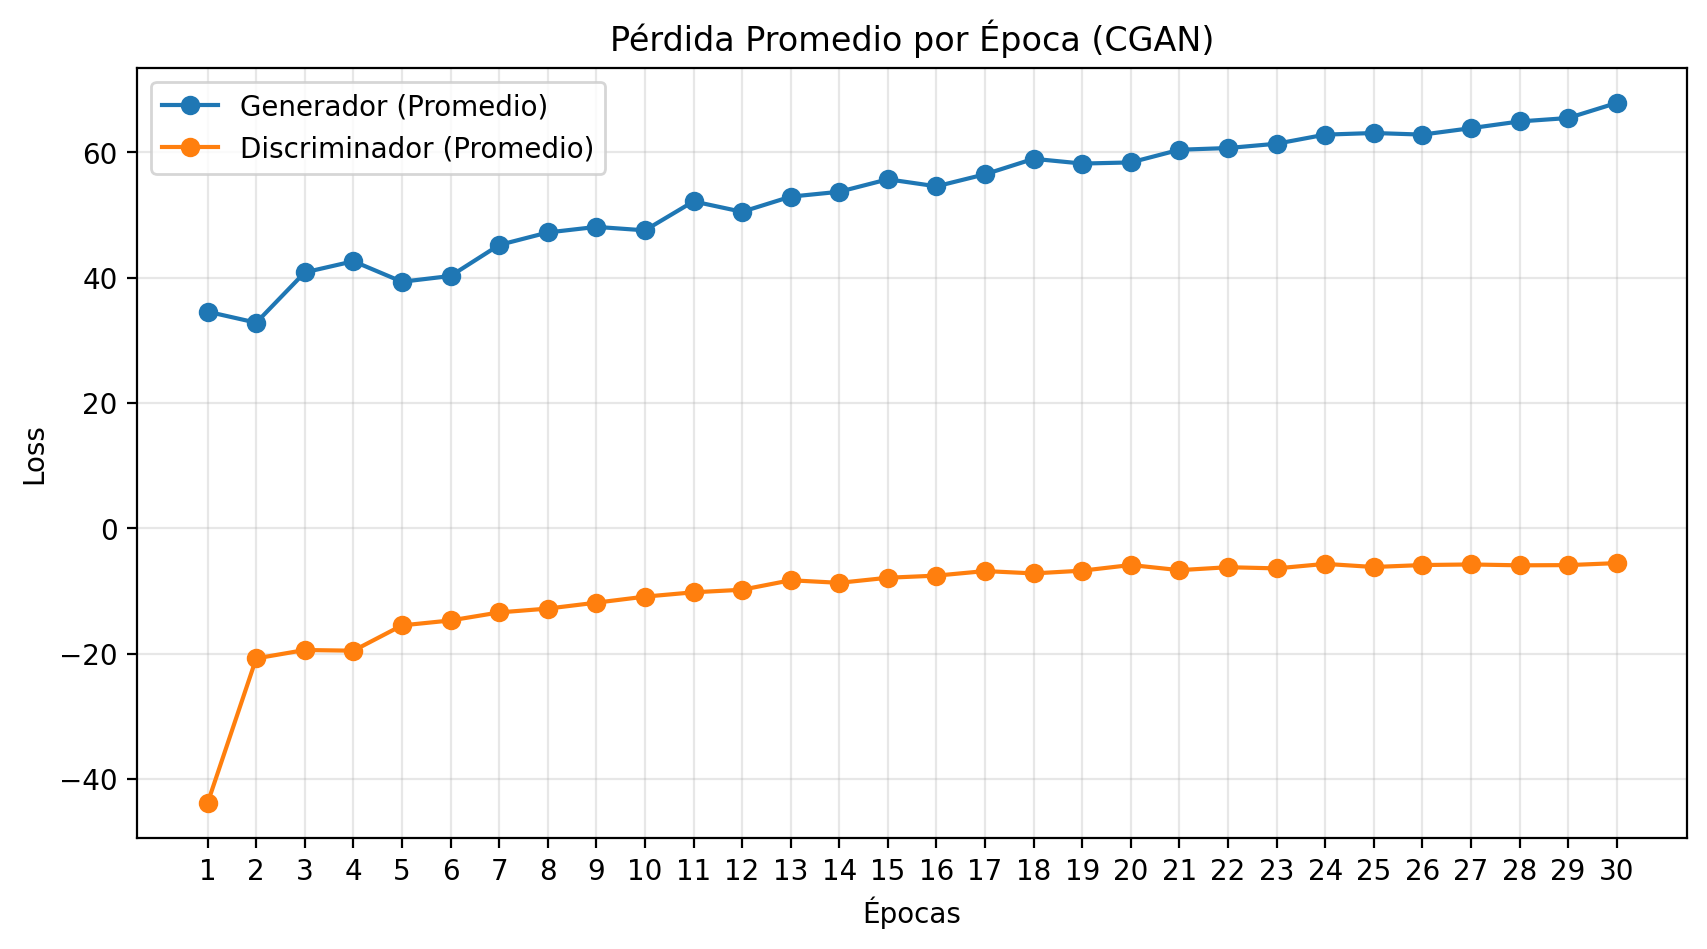

In [ ]:
G_losses_arr = np.array(G_losses)
D_losses_arr = np.array(D_losses)

# Dividimos el array total en trozos, uno por cada época
# np.array_split es inteligente y divide los datos equitativamente entre las 20 épocas
G_means = [np.mean(chunk) for chunk in np.array_split(G_losses_arr, num_epochs)]
D_means = [np.mean(chunk) for chunk in np.array_split(D_losses_arr, num_epochs)]

# Creamos el eje X (del 1 al 20)
epochs = range(1, num_epochs + 1)

# Graficamos
plt.figure(figsize=(10, 5))
plt.title("Pérdida Promedio por Época (CGAN)")
plt.plot(epochs, G_means, label="Generador (Promedio)", marker='o')
plt.plot(epochs, D_means, label="Discriminador (Promedio)", marker='o')

plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(epochs) # Asegura que muestre los números de las épocas enteros
plt.show()


Generando muestras condicionales...


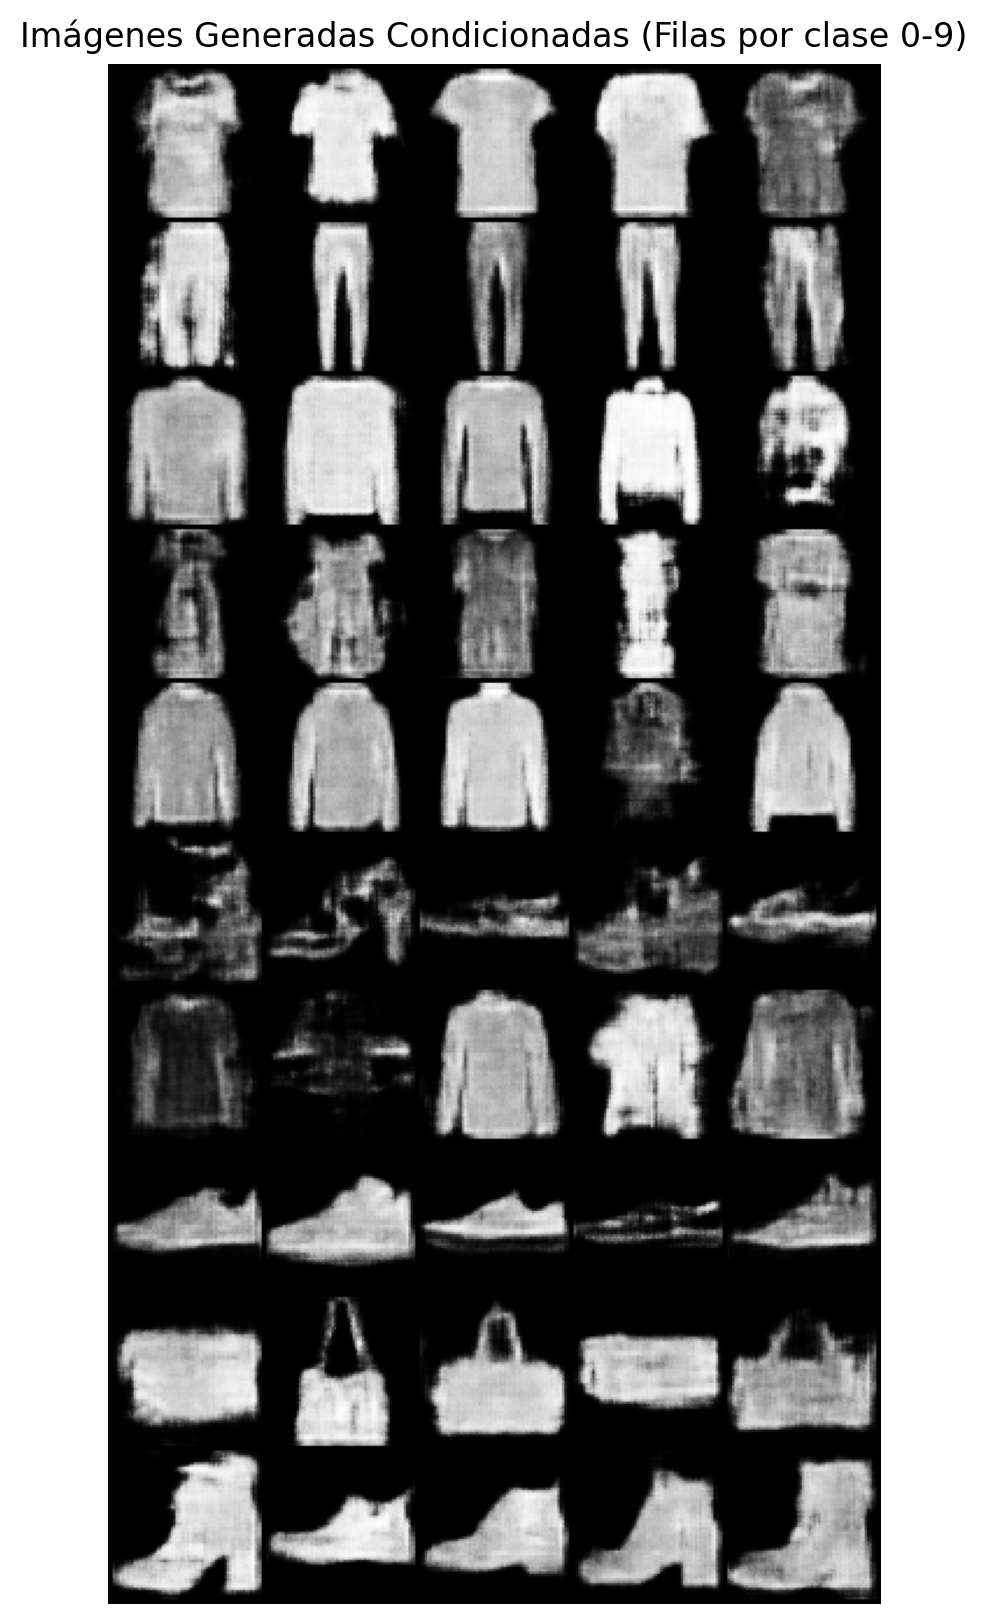

In [ ]:
# --- Generación final de muestras por etiqueta ---

print("\nGenerando muestras condicionales...")
netG.eval()
with torch.no_grad():
    # Generar 8 muestras por cada una de las 10 clases
    n_per_class = 5
    # Crear vector de ruido fijo
    z_vis = torch.randn(10 * n_per_class, nz, device=device)
    # Crear etiquetas ordenadas: 0,0,0... 1,1,1... 9,9,9
    labels_vis = torch.tensor([c for c in range(num_classes) for _ in range(n_per_class)], device=device)

    fake_imgs = netG(z_vis, labels_vis)

    # Visualizar
    plt.figure(figsize=(8, 10))
    plt.axis("off")
    plt.title("Imágenes Generadas Condicionadas (Filas por clase 0-9)")
    plt.imshow(np.transpose(vutils.make_grid(fake_imgs, padding=2, normalize=True, nrow=n_per_class).cpu(),(1,2,0)))
    plt.show()